In [2]:
"""

Functions to make hls maps

Created on Mon Jan 4, 2022

@author: pgoltstein
"""

import os
import importlib
import numpy as np
import pandas as pd
import h5py
import matplotlib
import matplotlib.pyplot as plt
import skimage.morphology
import skimage.filters
from skimage.transform import resize as imresize
from scipy.ndimage import gaussian_filter
from skimage.io import imread
from tqdm import tqdm

import sys
sys.path.insert(0, os.path.abspath(r'C:/Users/mmccann/repos/bonhoeffer/prey_capture/'))

import paths
import processing_parameters
import functions_bondjango as bd
import functions_data_handling as fdh
from functions_kinematic import wrap

# import xarray as xr
# from minian.motion_correction import apply_transform, estimate_motion
# from minian.preprocessing import denoise, remove_background
# from minian.utilities import get_optimal_chk, optimize_chunk, rechunk_like, load_videos
# from dask.distributed import Client, LocalCluster


In [14]:
def load_trialimages(plane_no, datapath):
    """ Loads a saved dfof responsemap of each trial into a 3d matrix [y_res,x_res,trials]
    """

    # Prepare filenames
    savedatapath = os.path.join(datapath,"hls")
    bsimages_file = os.path.join(savedatapath, "trialimages-bs-plane{}.npy".format(plane_no))
    stimimages_file = os.path.join(savedatapath, "trialimages-stim-plane{}.npy".format(plane_no))

    # Load df_images
    print("Loading baseline images from: {}".format(bsimages_file))
    bs_images = np.load(bsimages_file)
    print("Loading stimulus images from: {}".format(stimimages_file))
    stim_images = np.load(stimimages_file)

    # Return data
    return bs_images, stim_images


def process_trialimages( Imagestack, plane_no, frame_ixs, bs_frame_range, stim_frame_range, lightleak_value, datapath=None):
    """ Creates a for each trial a dfof responsemap and stores these in a 3d matrix [y_res,x_res,trials]
    """

    print("Creating trial images for: {}".format(datapath))

    # Create a folder for saving the data
    if datapath is not None:
        savedatapath = os.path.join(datapath,"hls")
        if not os.path.isdir(savedatapath):
            os.mkdir(savedatapath)
        bsimages_file = os.path.join(savedatapath, "trialimages-bs-plane{}.npy".format(plane_no))
        stimimages_file = os.path.join(savedatapath, "trialimages-stim-plane{}.npy".format(plane_no))

    # Get info on dimensions etc
    x_res, y_res = Imagestack.resolution
    n_trials = len(frame_ixs)

    # Prepare data containers
    bs_images = np.zeros( (x_res, y_res, n_trials) )
    stim_images = np.zeros( (x_res, y_res, n_trials) )

    # Suppress needles output and set plane
    old_verbose = Imagestack.verbose
    Imagestack.verbose = False
    Imagestack.plane = plane_no

    # Get the trial-wise images
    with tqdm(total=n_trials, desc="Reading", unit="trial") as bar:
        for trial,frame in enumerate(frame_ixs):

            # Load baseline images, take mean and add to data container
            I = Imagestack[ (frame+bs_frame_range[0]):(frame+bs_frame_range[1]) ]
            bs_images[:,:,trial] = np.mean(I,axis=2)-lightleak_value

            # Load stimulus images, take mean and add to data container
            I = Imagestack[ (frame+stim_frame_range[0]):(frame+stim_frame_range[1]) ]
            stim_images[:,:,trial] = np.mean(I,axis=2)-lightleak_value

            bar.update(1)

    # Convert images to 8 bit with global max at 255 and global min at 0
    min_all = np.min([np.min(bs_images),np.min(stim_images)])
    max_all = np.max([np.max(bs_images),np.max(stim_images)])
    bs_images = (((bs_images-min_all) / (max_all-min_all)) * 255).astype(np.uint8)
    stim_images = (((stim_images-min_all) / (max_all-min_all)) * 255).astype(np.uint8)

    # Save data if datapath was supplied
    if datapath is not None:
        print("Saving baseline images to: {}".format(bsimages_file))
        np.save(bsimages_file, bs_images)
        print("Saving stimulus images to: {}".format(stimimages_file))
        np.save(stimimages_file, stim_images)

    # Set verbose flag back to old value
    Imagestack.verbose = old_verbose

    # Return data
    return bs_images, stim_images


def process_trialimages_2(stack, bs_frame_idxs, stim_frame_idxs, lightleak_value=0, datapath=None):
    """ Creates for each trial a dfof responsemap and stores these in a 3d matrix [y_res,x_res,trials]
    """

    # Get info on dimensions etc
    x_res, y_res = stack.shape[1:]
    n_trials = len(stim_frame_idxs)

    # Prepare data containers
    bs_images = np.zeros( (x_res, y_res, n_trials) )
    stim_images = np.zeros( (x_res, y_res, n_trials) )

    # Get the trial-wise images
    with tqdm(total=n_trials, desc="Reading", unit="trial") as bar:
        for trial, (bs_frames, stim_frames) in enumerate(zip(bs_frame_idxs, stim_frame_idxs)):

            # Load baseline images, take mean and add to data container
            I = stack[bs_frames, :, :]
            bs_images[:,:,trial] = np.mean(I,axis=0) - lightleak_value

            # Load stimulus images, take mean and add to data container
            I = stack[stim_frames, :, :]
            stim_images[:,:,trial] = np.mean(I,axis=0) - lightleak_value

            bar.update(1)

    # Convert images to 8 bit with global max at 255 and global min at 0
    min_all = np.min([np.min(bs_images),np.min(stim_images)])
    max_all = np.max([np.max(bs_images),np.max(stim_images)])
    bs_images = (((bs_images-min_all) / (max_all-min_all)) * 255).astype(np.uint8)
    stim_images = (((stim_images-min_all) / (max_all-min_all)) * 255).astype(np.uint8)

    # Return data
    return bs_images, stim_images


def hlsmap( hlsname, stimuli, bs_images, stim_images, max_dfof=0, colormap="hsv", datapath=None, aspect_ratio=1.0, scale_by_im=None, show_colorbar=True ):
    """ Creates an HLS map as RGB array [yres,xres,rgb]
    """

    print("Creating hlsmap for: {}".format(hlsname))

    # Create a folder for saving the data
    if (datapath is not None) and (len(hlsname.strip()) > 0):
        savedatapath = os.path.join(datapath,"hls")
        if not os.path.isdir(savedatapath):
            os.mkdir(savedatapath)
    else:
        savedatapath = ""

    # Get info on dimensions etc
    x_res, y_res, n_trials = bs_images.shape
    unique_stimuli = np.unique(stimuli)
    n_stimuli = len(unique_stimuli)

    # Prepare colorspace
    colors = np.zeros((n_stimuli,3))
    if colormap.lower() == "eye":
        colors[0,:] = [1.0, 0.0, 0.0]
        colors[1,:] = [0.0, 0.0, 1.0]
    elif colormap.lower() == "eye-reverse":
        colors[0,:] = [0.0, 0.0, 1.0]
        colors[1,:] = [1.0, 0.0, 0.0]
    elif colormap.lower() == "category":
        colors[0,:] = [0.0, 0.8, 1.0]
        colors[1,:] = [1.0, 0.0, 0.4]
    elif colormap.lower() == "category-reverse":
        colors[0,:] = [1.0, 0.0, 0.4]
        colors[1,:] = [0.0, 0.8, 1.0]
    elif colormap.lower() == "3colors":
        colors[0,:] = [1.0, 0.0, 0.0]
        colors[1,:] = [0.0, 1.0, 0.0]
        colors[2,:] = [0.0, 0.0, 1.0]
    elif colormap.lower() == "3colors-reverse":
        colors[2,:] = [1.0, 0.0, 0.0]
        colors[1,:] = [0.0, 1.0, 0.0]
        colors[0,:] = [0.0, 0.0, 1.0]
    elif colormap.lower() == "5colors":
        colors[0,:] = [1.0, 0.0, 0.0]
        colors[1,:] = [1.0, 1.0, 0.0]
        colors[2,:] = [0.0, 1.0, 0.0]
        colors[3,:] = [0.0, 1.0, 1.0]
        colors[4,:] = [0.0, 0.0, 1.0]
    elif colormap.lower() == "5colors-reverse":
        colors[4,:] = [1.0, 0.0, 0.0]
        colors[3,:] = [1.0, 1.0, 0.0]
        colors[2,:] = [0.0, 1.0, 0.0]
        colors[1,:] = [0.0, 1.0, 1.0]
        colors[0,:] = [0.0, 0.0, 1.0]
    else:
        cmap = matplotlib.cm.get_cmap(colormap)
        if colormap == "hsv":
            for s in range(n_stimuli):
                colors[s,:] = cmap(float(s)/n_stimuli)[:3]
        else:
            for s in range(n_stimuli):
                colors[s,:] = cmap(float(s)/(n_stimuli-1))[:3]

    print("bs_images: {}  {}".format(np.nanmin(bs_images),np.nanmax(bs_images)))
    print("stim_images: {}  {}".format(np.nanmin(stim_images),np.nanmax(stim_images)))

    # Filter images (smoothing)
    disk_kernel = skimage.morphology.disk(radius=1)
    with tqdm(total=n_trials, desc="Filtering", unit="trial") as bar:
        for t in range(n_trials):
            bs_images[:,:,t] = skimage.filters.rank.median(bs_images[:,:,t], selem=disk_kernel)
            stim_images[:,:,t] = skimage.filters.rank.median(stim_images[:,:,t], selem=disk_kernel)
            bar.update(1)

    print("bs_images: {}  {}".format(np.nanmin(bs_images),np.nanmax(bs_images)))
    print("stim_images: {}  {}".format(np.nanmin(stim_images),np.nanmax(stim_images)))

    # Prepare data containers
    df_images = np.zeros( (x_res, y_res, n_stimuli) )

    # Get one average baseline image and set minimum value to 1
    bs_im = np.mean(bs_images, axis=2)
    bs_im[bs_im<1] = 1.0
    print("bs_im: {}  {}".format(np.nanmin(bs_im), np.nanmax(bs_im)))

    # Get one df/f image per stimulus
    for stim_nr,stim_id in enumerate(unique_stimuli):

        # Get indices for this stimulus id
        stim_indices = stimuli==stim_id

        # Mean, and df/f
        df_images[:,:,stim_nr] = (np.nanmean(stim_images[:,:,stim_indices], axis=2) - bs_im) / bs_im

    print("df_images: {}  {}".format(np.nanmin(df_images), np.nanmax(df_images)))

    # Change to correct aspect ratio
    if aspect_ratio != 1.0:
        print("Correcting to aspect ratio {}".format(aspect_ratio))
        new_x = int(x_res * aspect_ratio)
        df_images_new = np.zeros((y_res,new_x,n_stimuli))
        for s in range(n_stimuli):
            df_images_new[:,:,s] = imresize(df_images[:,:,s], (y_res,new_x), order=0)
        x_res = new_x
        df_images = df_images_new

    # Create H map (hue=stim preference)
    H = np.argmax(df_images, axis=2)
    # print("H: {}  {}".format(np.nanmin(H),np.nanmax(H)))

    # Create L map (lightness=response amplitude) and clip responses to range
    if max_dfof == 0:
        max_dfof = np.round(np.percentile(df_images.ravel(), 99) * 100)
        if scale_by_im is not None:
            max_dfof = np.round(max_dfof * 0.75)
    L = np.nanmax(df_images, axis=2) * (100/float(max_dfof))
    L[L<0] = 0.0
    # print("L: {}  {}".format(np.nanmin(L),np.nanmax(L)))

    # Calculate resultant and circular variance for 'S' (saturation=selectivity)
    phasor = np.zeros( (y_res, x_res, n_stimuli), dtype=np.complex_)
    amp_sorted = np.sort(df_images, axis=2)
    amp_sorted[amp_sorted<0.0001] = 0.0001
    min_as = np.nanmin(amp_sorted)
    max_as = np.nanmax(amp_sorted)
    amp_sorted = (amp_sorted-min_as) / (max_as-min_as)
    for s in range(n_stimuli):
        phasor[:,:,s] = amp_sorted[:,:,s] * np.exp( 1j * (s/n_stimuli) * 2 * np.pi)
    resultant = np.abs(np.sum(phasor,axis=2)) / np.sum(np.abs(phasor),axis=2)
    circvar = 1-resultant

    # Convert H map to RGB
    H = colors[H]

    # Stack L, circvar and resultant to 3d arrays
    L = np.stack([L,L,L], axis=2)
    resultant = np.stack([resultant,resultant,resultant], axis=2)
    circvar = np.stack([circvar,circvar,circvar], axis=2)

    # Add amplitude and saturarion by elementwise multiplications
    HLS = (H * L * resultant) + L * circvar
    # print("HLS {}  {}".format(np.nanmin(HLS),np.nanmax(HLS)))
    
    # If scale_by_im is set, scale the brightness by the supplied image
    if scale_by_im is not None:
        scale_max = np.percentile(scale_by_im.ravel(),99)
        scale_min = np.percentile(scale_by_im.ravel(),1)
        scale_by_im = (scale_by_im - scale_min) / (scale_max - scale_min)

        if aspect_ratio != 1.0:
            scale_by_im = imresize(scale_by_im, (y_res,x_res), order=0)

        scale_by_im[scale_by_im>1.0] = 1.0
        scale_by_im[scale_by_im<0.0] = 0.0
        scale_by_im = np.stack([scale_by_im,scale_by_im,scale_by_im], axis=2)
        HLS = HLS * scale_by_im

    HLSmax = np.nanmax(HLS,axis=2)
    HLSmax[HLSmax<1.0] = 1.0
    HLSmax = np.stack([HLSmax,HLSmax,HLSmax], axis=2)
    HLS = HLS / HLSmax
    # print("HLS after scaling {}  {}".format(np.nanmin(HLS),np.nanmax(HLS)))

    if show_colorbar:
        color_bar = np.zeros((10,x_res)).astype(int)
        x_offset = int(0.1 * x_res)
        x_res_offsetted = int(x_res - (2*x_offset))
        
        # Create full bar
        for stim_nr in range(n_stimuli):
            x_start = int( (stim_nr/n_stimuli) * x_res_offsetted ) + x_offset
            x_end = int( ((stim_nr+1)/n_stimuli) * x_res_offsetted ) + x_offset
            color_bar[:,x_start:x_end] = stim_nr
        color_bar = colors[color_bar]

        # Now black out edges
        color_bar[:,:x_offset,:] = 0
        color_bar[:,-x_offset:,:] = 0
        for stim_nr in range(n_stimuli):
            x_start = int( ((stim_nr/n_stimuli) * x_res_offsetted) ) + x_offset
            x_end   = int( ((stim_nr/n_stimuli) * x_res_offsetted) + (0.2*(x_res_offsetted/n_stimuli)) ) + x_offset
            color_bar[:,x_start:x_end,:] = 0
            x_start = int( ( ((stim_nr+1)/n_stimuli) * x_res_offsetted) - (0.2*(x_res_offsetted/n_stimuli)) ) + x_offset
            x_end   = int( ( ((stim_nr+1)/n_stimuli) * x_res_offsetted) ) + x_offset
            color_bar[:,x_start:x_end,:] = 0
        HLS = np.concatenate([HLS,color_bar], axis=0)

    if savedatapath:
        hlsmap_name = "hls-" + hlsname + '-max{:02.0f}'.format(max_dfof)
        if scale_by_im is not None:
            hlsmap_name = hlsmap_name + "-adjusted"
        hlsmap_file = os.path.join(savedatapath, hlsmap_name + '.png')
        print("Saving hlsmap to file: {}".format(hlsmap_file))
        plt.imsave(hlsmap_file, HLS)

    return HLS

In [16]:
importlib.reload(processing_parameters)
# get the search query
search_string = processing_parameters.search_string
parsed_search_string = fdh.parse_search_string(search_string)

# get the paths from the database
all_processed = bd.query_database('analyzed_data', search_string + ', analysis_type:preprocessing')
preproc_paths = [el['analysis_path'] for el in all_processed if ('_preproc' in el['slug']) and (parsed_search_string['mouse'].lower() in el['slug'])]

all_raw = bd.query_database('vr_experiment', search_string)
ca_paths = [el['tif_path'] for el in all_raw if (parsed_search_string['mouse'].lower() in el['slug'])]

# get the day, animal and rig
day = '_'.join(all_processed[0]['slug'].split('_')[0:3])
rig = all_processed[0]['rig']
animal = all_processed[0]['slug'].split('_')[3:6]
animal = '_'.join([animal[0].upper()] + animal[1:])

# assemble the output path
out_path = os.path.join(paths.analysis_path, '_'.join((day, animal, rig, 'tcday.hdf5')))

# allocate memory for the data
preproc_data = []
ca_stacks = []

# allocate memory for excluded trials
excluded_trials = []

# for all the files
for preproc_file, ca_file in zip(preproc_paths, ca_paths):
    # load the data
    with pd.HDFStore(preproc_file, mode='r') as h:
        if ('/matched_calcium' in h.keys()):
            # concatenate the latents
            dataframe = h['matched_calcium']
            # store
            preproc_data.append(dataframe)

            # Load the ca stack as well
            stack = imread(ca_file).astype(np.uint8)

            # replace nans with 0
            stack = np.nan_to_num(stack, 0)

            # if it's 2d (i.e 1 frame), expand 1 dimension
            if len(stack.shape) == 2:
                stack = np.expand_dims(stack, 2)
                stack = np.transpose(stack, [2, 0, 1])

            ca_stacks.append(stack)

        else:
            excluded_trials.append(preproc_file)

print(f'Number of files loaded: {len(preproc_data)}')

Number of files loaded: 1


In [5]:
def calculate_angles(ds):
    # explicitly calculate direction and orienation in the dataset
    if 'direction_wrapped' not in ds.columns:
        ds['direction_wrapped'] = ds['direction'].copy()
        mask = ds['direction_wrapped'] > -1000
        ds.loc[mask, 'direction_wrapped'] = ds.loc[mask, 'direction_wrapped'].apply(wrap, bound=360.1)

    if 'orientation' not in ds.columns:
        ds['orientation'] = ds['direction_wrapped'].copy()
        mask = ds['orientation'] > -1000
        ds.loc[mask, 'orientation'] = ds.loc[mask, 'orientation'].apply(wrap, bound=180.1)
    return ds

def parse_trial_frames(df, prestim=0, poststim=0, get_baseline=False):
    fr = processing_parameters.wf_frame_rate

    if get_baseline:
        trial_idx_frames = df[df.trial_num > 0].groupby(['trial_num']).apply(lambda x: [x.index[0]-int(fr*prestim), x.index[1]])
    else:
        trial_idx_frames = df[df.trial_num > 0].groupby(['trial_num']).apply(lambda x: [x.index[0]-int(fr*prestim), x.index[-1]+int(fr*poststim)])
        
    trial_idx_frames = np.array(trial_idx_frames.to_list())

    if trial_idx_frames[-1, 1] > df.index[-1]:
        trial_idx_frames[-1, 1] = df.index[-1]
    if trial_idx_frames[0, 0] < 0:
        trial_idx_frames[0, 0] = 0

    traces = []
    for i, frame in enumerate(trial_idx_frames):
        df_slice = df.iloc[frame[0]:frame[1], :].copy()
        df_slice['trial_num'] = i + 1
        df_slice['direction'] = df_slice['direction'].max()
        df_slice['direction_wrapped'] = df_slice['direction_wrapped'].max()
        df_slice['orientation'] = df_slice['orientation'].max()
        traces.append(df_slice)
    
    traces = pd.concat(traces, axis=0).reset_index(drop=False)
    return traces

def drop_partial_or_long_trials(df, min_trial_length=4.5, max_trial_length=5.5):
    trial_lengths = df[df.trial_num > 0].groupby('trial_num').apply(lambda x: x.shape[0] / processing_parameters.wf_frame_rate)

    # Drop trials that are shorter than min_trial_length (partial trials)
    short_trials = trial_lengths[trial_lengths < min_trial_length].index
    df = df.drop(df[df.trial_num.isin(short_trials)].index)

    # Drop trials that are longer than max_trial_length (errors in trial number indexing)
    long_trials = trial_lengths[trial_lengths > max_trial_length].index
    df = df.drop(df[df.trial_num.isin(long_trials)].index)

    return df

def get_stim_and_basline_idxs(ds, variable):
    # Do a groupby to get the trial frames
    stim_df = parse_trial_frames(ds)
    stim_frames = stim_df[stim_df.trial_num > 0].groupby([variable, 'trial_num']).index.agg(list).droplevel(-1).to_list()
    stims = stim_df[stim_df.trial_num > 0].groupby([variable, 'trial_num']).index.agg(list).droplevel(-1).index.to_numpy()

    # Do another groupby to get the trial baseline frames
    bs_df = parse_trial_frames(ds, prestim=2, get_baseline=True)
    bs_frames = bs_df[bs_df.trial_num > 0].groupby([variable, 'trial_num']).index.agg(list).droplevel(-1).to_list()

    return stim_frames, bs_frames, stims

In [17]:
# Load the data and trim the tif stack
ds = preproc_data[0]
stack = ca_stacks[0]
processed_frames = ds['ca_tif_frames'].to_numpy()
stack = stack[processed_frames, :, :]

In [ ]:
# cluster = LocalCluster(
#     n_workers=4,
#     memory_limit="5GB",
#     resources={"MEM": 1},
#     threads_per_worker=2,
#     dashboard_address=":8787",
# )
# client = Client(cluster)

# # Use minian to do motion correction on the stack
# varr = xr.DataArray(stack, dims=('frame', 'height', 'width'), name='varr')
# varr = varr.assign_coords(frame=np.arange(varr.shape[0]), height=np.arange(varr.shape[1]), width=np.arange(varr.shape[2]))
# chk, _ = get_optimal_chk(varr, dtype=float)
# varr = optimize_chunk(varr, chk)

# # remove glow
# varr_ref = varr.sel(None) 
# varr_ref.rename("varr_ref")
# varr_min = varr_ref.chunk({"frame": -1, "height": -1, "width": -1}).quantile(0.0025, dim="frame", skipna=True).compute()
# varr_min = varr_min - np.min(varr_min)
# varr_ref = varr_ref - varr_min
# varr_ref = varr_ref.where(varr_ref > 0, 0).astype(np.uint8)
# varr_ref = rechunk_like(varr_ref, varr)

# param_denoise = {"method": "median", "ksize": 5}
# param_background_removal = {"method": "tophat", "wnd": 15}
# param_estimate_motion = {"dim": "frame", "npart": 5, "aggregation": "mean"}

# # denoise
# varr_ref = denoise(varr_ref, **param_denoise)

# # remove background
# varr_ref = remove_background(varr_ref, **param_background_removal)

# # estimate motion
# motion = estimate_motion(varr_ref, **param_estimate_motion)
# Y = apply_transform(varr_ref, motion, fill=0)

# aligned_stack = Y.compute()

In [23]:
# Do a groupby to get the baseline frames
var = 'orientation'
ds = calculate_angles(ds)
ds = drop_partial_or_long_trials(ds)
stim_frames, bs_frames, stims = get_stim_and_basline_idxs(ds, var)
baseline_idx_frames = ds[ds.trial_num == 0].ca_tif_frames.to_numpy()
mean_im = np.mean(stack, axis=0)

Reading: 100%|██████████| 120/120 [00:02<00:00, 52.70trial/s]


Creating hlsmap for: orientation
bs_images: 0  255
stim_images: 0  255


Filtering:   0%|          | 0/120 [00:00<?, ?trial/s]C:\Users\mmccann\AppData\Local\Temp\ipykernel_20332\3207349548.py:186: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  bs_images[:,:,t] = skimage.filters.rank.median(bs_images[:,:,t], selem=disk_kernel)
C:\Users\mmccann\AppData\Local\Temp\ipykernel_20332\3207349548.py:187: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  stim_images[:,:,t] = skimage.filters.rank.median(stim_images[:,:,t], selem=disk_kernel)
Filtering: 100%|██████████| 120/120 [00:02<00:00, 50.22trial/s]
C:\Users\mmccann\AppData\Local\Temp\ipykernel_20332\3207349548.py:244: RuntimeWarning: invalid value encountered in divide
  resultant = np.abs(np.sum(phasor,axis=2)) / np.sum(np.abs(phasor),axis=2)
C:\Users\mmccann\AppData\Local\Temp\ipykernel_20332\3207349548.py:273: RuntimeWarning: All-NaN sli

bs_images: 0  255
stim_images: 0  255
bs_im: 1.0  254.925
df_images: -1.0  0.5510204081632651


c:\Users\mmccann\miniconda3\envs\prey_capture_old\lib\site-packages\matplotlib\cm.py:496: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


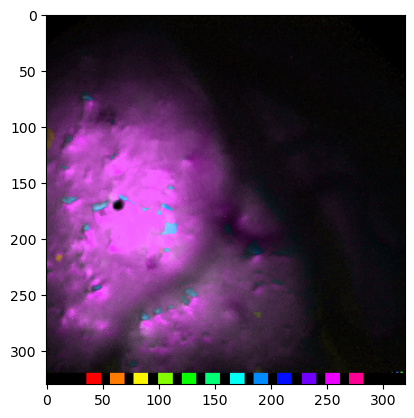

In [24]:
bs_images, stim_images = process_trialimages_2(stack, bs_frames, stim_frames, lightleak_value=0, datapath=None)
hls = hlsmap(var, stims, bs_images, stim_images, max_dfof=0, colormap="hsv", datapath=None, aspect_ratio=1.0, scale_by_im=mean_im, show_colorbar=True)
plt.imshow(hls)